# **Project \#1: YOLOv3**

Slides: [Google slide](https://docs.google.com/presentation/d/1Z-vy-vwgPBlWe96Ex_U6ZE6PcVB6gtepsZpsPLnwNO0/edit?usp=sharing)

Objectives:
* Use YOLOv3 to practice the object detection task.
* Get familiar with PyTorch & YOLOv3.

If any questions, please contact the TAs via email:
* Yu-Lin Lu: sinicayllu@iis.sinica.edu.tw
* Hung-Shuo Chang: jonathanc@iis.sinica.edu.tw

This notebook:

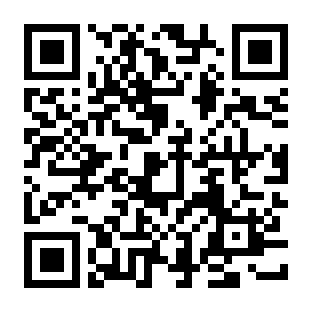

## **Introduction**

YOLO is a series of real-time object detection algorithm.

YOLOv3 ([paper](https://arxiv.org/pdf/1804.02767.pdf)):
1. Anchor Based
2. Darknet-53
3. Feature Pyramid Networks (FPN)



### **Darknet-53**

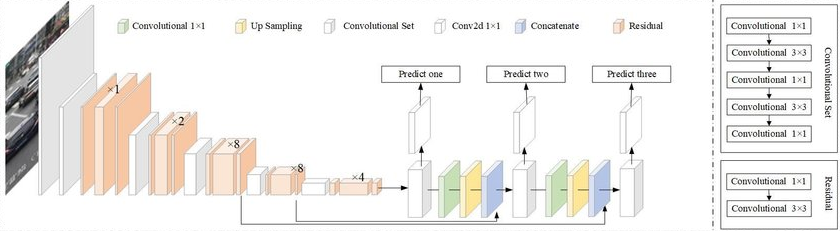

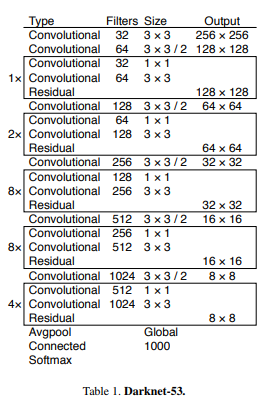

# **Environment Checking**

Please make sure your runtime type is ***GPU*** or ***TPU***

Check GPU by using the following command:

In [ ]:
!nvidia-smi

Thu Apr 13 07:07:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Setup YOLOv3**

This section is used to setup YOLOv3 and its environment.

## **Download Project**

We use [ultralytics/yolov3](https://github.com/ultralytics/yolov3), which is pytorch version and is made by the author of YOLOv5.

Use `git clone` command for download project from github.

In [ ]:
!git clone https://github.com/ws6125/yolov3_pytorch.git

Cloning into 'yolov3_pytorch'...
remote: Enumerating objects: 10094, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10094 (delta 1), reused 3 (delta 0), pack-reused 10088
Receiving objects: 100% (10094/10094), 9.38 MiB | 18.55 MiB/s, done.
Resolving deltas: 100% (6806/6806), done.


## **Install required packages**

In [ ]:
%cd yolov3_pytorch
%pip install -r requirements.txt

/content/yolov3_pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00


# **Download Dataset**

## **Dataset: VisDrone**

VisDrone is a large-scale benchmark with annotated ground-truth for various important computer vision tasks.

We use **VisDrone2019** as example:

In [ ]:
from utils.general import download, Path

dir = Path('../datasets')  # dataset root dir
urls = ['https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-train.zip',
        'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-val.zip',
        'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-dev.zip',
        'https://github.com/ultralytics/yolov5/releases/download/v1.0/VisDrone2019-DET-test-challenge.zip']
download(urls, dir=dir)
print('Done!')

  0%|          | 0.00/1.44G [00:00<?, ?B/s]

Unzipping ../datasets/VisDrone2019-DET-train.zip...


  0%|          | 0.00/77.9M [00:00<?, ?B/s]

Unzipping ../datasets/VisDrone2019-DET-val.zip...


  0%|          | 0.00/297M [00:00<?, ?B/s]

Unzipping ../datasets/VisDrone2019-DET-test-dev.zip...


  0%|          | 0.00/292M [00:00<?, ?B/s]

Unzipping ../datasets/VisDrone2019-DET-test-challenge.zip...
Done!


## **Adjust Annotation Format**

Convert annotations to YOLOv3 format:

In [ ]:
from utils.general import os, Path

def visdrone2yolo(dir):
    from PIL import Image
    from tqdm import tqdm

    def convert_box(size, box):
        # Convert VisDrone box to YOLO xywh box
        dw = 1. / size[0]
        dh = 1. / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh

    (dir / 'labels').mkdir(parents=True, exist_ok=True)  # make labels directory
    pbar = tqdm((dir / 'annotations').glob('*.txt'), desc=f'Converting {dir}')
    for f in pbar:
        img_size = Image.open((dir / 'images' / f.name).with_suffix('.jpg')).size
        lines = []
        with open(f, 'r') as file:  # read annotation.txt
            for row in [x.split(',') for x in file.read().strip().splitlines()]:
                if row[4] == '0':  # VisDrone 'ignored regions' class 0
                    continue
                cls = int(row[5]) - 1
                box = convert_box(img_size, tuple(map(int, row[:4])))
                lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
                with open(str(f).replace(os.sep + 'annotations' + os.sep, os.sep + 'labels' + os.sep), 'w') as fl:
                    fl.writelines(lines)  # write label.txt

In [ ]:
for d in ['VisDrone2019-DET-train', 'VisDrone2019-DET-val', 'VisDrone2019-DET-test-dev']:
    visdrone2yolo(dir / d)  # convert VisDrone annotations to YOLO labels
print("\nDone!")

Converting ../datasets/VisDrone2019-DET-train: 6471it [00:41, 157.75it/s]
Converting ../datasets/VisDrone2019-DET-val: 548it [00:04, 123.37it/s]
Converting ../datasets/VisDrone2019-DET-test-dev: 1610it [00:08, 180.47it/s]


Done!


Modify the path of dataset in **yaml file**:

In [ ]:
import yaml

yaml_file = 'data/VisDrone.yaml'

# read yaml file
with open(yaml_file) as f:
    yaml_dict = yaml.load(f, Loader=yaml.loader.SafeLoader)

yaml_dict['path'] = str(dir)

# write yaml file
with open(yaml_file, 'w') as f:
    data = yaml.dump(yaml_dict, f, sort_keys=False, default_flow_style=False)

# **Use YOLOv3**

The following steps will show you how to use YOLOv3:
1. Training
2. Validation
3. Inference
4. Visualize



## **Training**

Train a YOLOv3 model on the dataset.

You can also set `--weights` parameter to use a pre-train model.

In [ ]:
!rm -rf runs/train
!python train.py --img 640 --batch 16 --epochs 8 --weights '' --cfg models/yolov3.yaml --hyp data/hyps/hyp.scratch-high.yaml --data data/VisDrone.yaml --cache

train: weights=, cfg=models/yolov3.yaml, data=data/VisDrone.yaml, hyp=data/hyps/hyp.scratch-high.yaml, epochs=8, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ws6125/yolov3_pytorch ✅
YOLOv3 🚀 81867be torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.1, lrf=0.2, momentum=0.937, weight_decay=0.0001, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.01, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale

## **Validation**

Validate the model by using validation set.

You should change the `--weight` parameter to your own model.

In [ ]:
!rm -rf runs/val
!python val.py --img 640 --weights runs/train/exp/weights/last.pt --data data/VisDrone.yaml --img 640 --iou 0.65

val: data=data/VisDrone.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv3 🚀 81867be torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
val: Scanning '../datasets/VisDrone2019-DET-val/labels.cache' images and labels... 548 found, 0 missing, 0 empty, 0 corrupted: 100% 548/548 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 18/18 [00:41<00:00,  2.33s/it]
                 all        548      38759      0.506      0.221      0.174      0.082
          pedestrian        548       8844      0.254      0.388      0.288        0.1
              people        548       5125      0.32

## **Inference**

Inference images by using YOLOv3 model.

You should change the `--weight` parameter to your own model.

`--source` provides image, video, and directory. ([ref](https://colab.research.google.com/github/ultralytics/yolov3/blob/master/tutorial.ipynb#scrollTo=4JnkELT0cIJg))

In [ ]:
!rm -rf runs/detect
!python detect.py --weights runs/train/exp/weights/last.pt --source ../datasets/VisDrone2019-DET-test-challenge/images/0000000_00098_d_0000001.jpg --img 640 --conf 0.25

detect: weights=['runs/train/exp/weights/last.pt'], source=../datasets/VisDrone2019-DET-test-challenge/images/0000000_00098_d_0000001.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 81867be torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
image 1/1 /content/datasets/VisDrone2019-DET-test-challenge/images/0000000_00098_d_0000001.jpg: 384x640 19 pedestrians, 11 cars, Done. (0.043s)
Speed: 0.4ms pre-process, 43.3ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


## **Visualize**

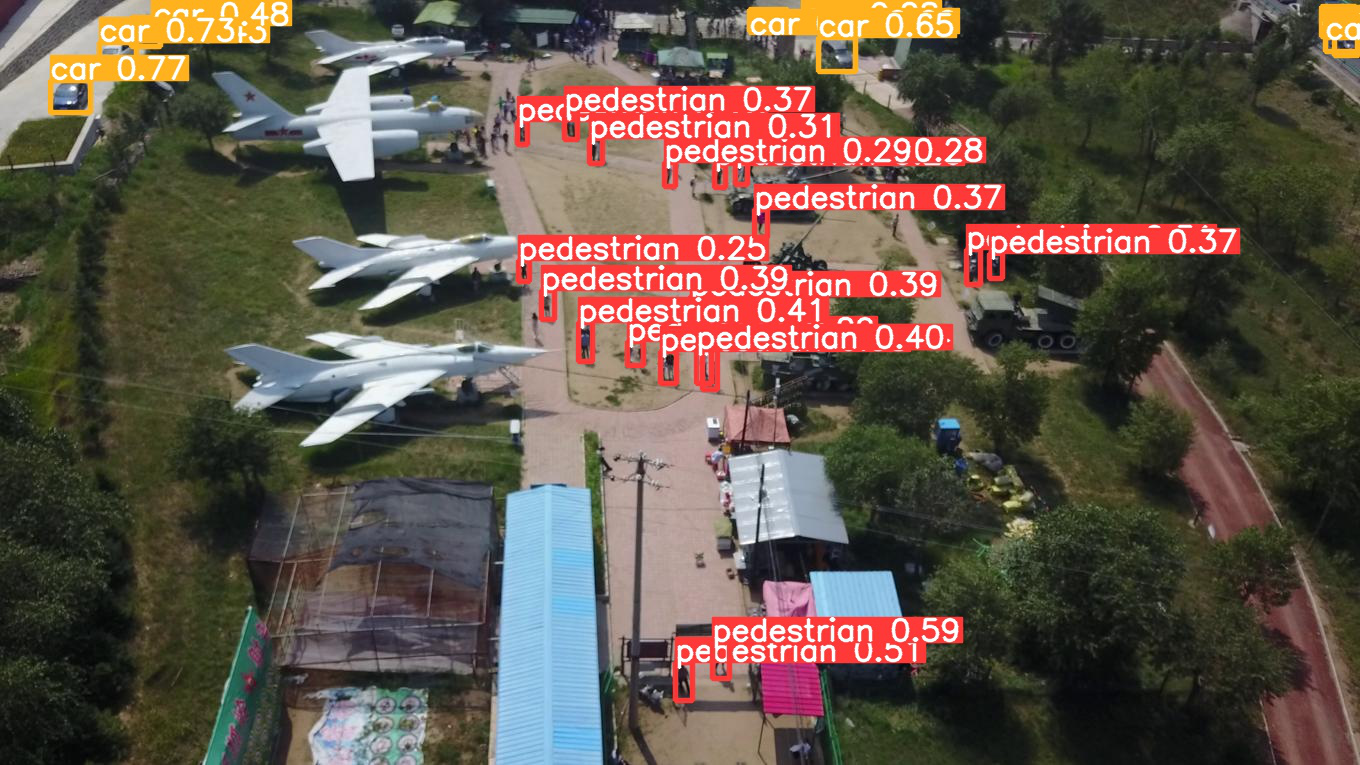

In [ ]:
# import cv2
# from matplotlib import pyplot as plt

# img = cv2.imread('runs/detect/exp/0000000_00098_d_0000001.jpg', cv2.IMREAD_COLOR)
# # cv2.imshow('color image', img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

from PIL import Image
img = Image.open('runs/detect/exp/0000000_00098_d_0000001.jpg')
display(img)

# **Report**

## **Do it yourself**

Please use the YOLOv3 and another dataset to train your own object detection model.

Dataset: [Car Object Detection](https://www.kaggle.com/datasets/sshikamaru/car-object-detection)

You have to convert the annotations in csv to YOLOv3 format. ([ref](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data))

You also need to adjust hyperparameters to get better performance.
**Hint**:
1. hyp yaml file in *data/hyps* folder
2. train.py



## **Deadline**

**2023/04/28**